In [6]:
# install packages
!pip -q install GEOparse pandas numpy scipy scikit-learn matplotlib seaborn statsmodels

In [7]:
# load data
import os, re, numpy as np, pandas as pd
import GEOparse

# Download GEO Series (this pulls metadata + links to processed data)
gse = GEOparse.get_GEO("GSE15852", destdir=".", silent=True)

# The series-matrix file has an expression table per sample with probe IDs as rows.
# Extract sample-level tables and merge into a single matrix.
expr_list = []
sample_labels = []

for gsm_name, gsm in gse.gsms.items():
    tbl = gsm.table
    # Affymetrix processed tables typically have 'ID_REF' (probe) and 'VALUE'
    if {"ID_REF","VALUE"}.issubset(tbl.columns):
        df = tbl[["ID_REF","VALUE"]].rename(columns={"VALUE": gsm_name})
        expr_list.append(df)
        # phenotype: "Cancer" vs "Normal" is in gsm.metadata['title'] or 'source_name_ch1'
        meta = {k:" ".join(v) for k,v in gsm.metadata.items()}
        label = "Cancer" if re.search(r'\b(cancer|tumou?r|tumor)\b', (meta.get("title","")+meta.get("source_name_ch1","")).lower()) else "Normal"
        sample_labels.append((gsm_name, label))

# Join all samples on probe ID
expr = expr_list[0]
for df in expr_list[1:]:
    expr = expr.merge(df, on="ID_REF", how="inner")

expr = expr.set_index("ID_REF")
expr = expr.apply(pd.to_numeric, errors="coerce")

# Build phenotype/metadata frame
pheno = pd.DataFrame(sample_labels, columns=["sample","status"]).set_index("sample").loc[expr.columns]

print("Expression matrix shape:", expr.shape)
print(pheno["status"].value_counts())
expr.head().iloc[:,:5]


Expression matrix shape: (22283, 86)
status
Normal    43
Cancer    43
Name: count, dtype: int64


,GSM398074,GSM398075,GSM398076,GSM398077,GSM398078
ID_REF,,,,,
AFFX-BioB-5_at,136.0530,58.7337,84.9808,347.8130,237.2410
AFFX-BioB-M_at,47.0579,45.7795,45.4352,49.7853,59.3774
AFFX-BioB-3_at,33.0177,12.0183,44.7253,35.9153,29.5797
AFFX-BioC-5_at,299.1150,150.4790,215.6680,414.4940,476.8530
AFFX-BioC-3_at,78.2083,61.5917,81.6082,56.1327,48.0321


In [8]:
#check missing or null values
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check missing values
missing_total = expr.isna().sum().sum()
print("Total missing values in matrix:", missing_total)

# Replace missing values with median expression of that probe (recommended for microarray data)
expr = expr.apply(lambda x: x.fillna(x.median()))

print("Any remaining missing?", expr.isna().sum().sum())


Total missing values in matrix: 0
Any remaining missing? 0


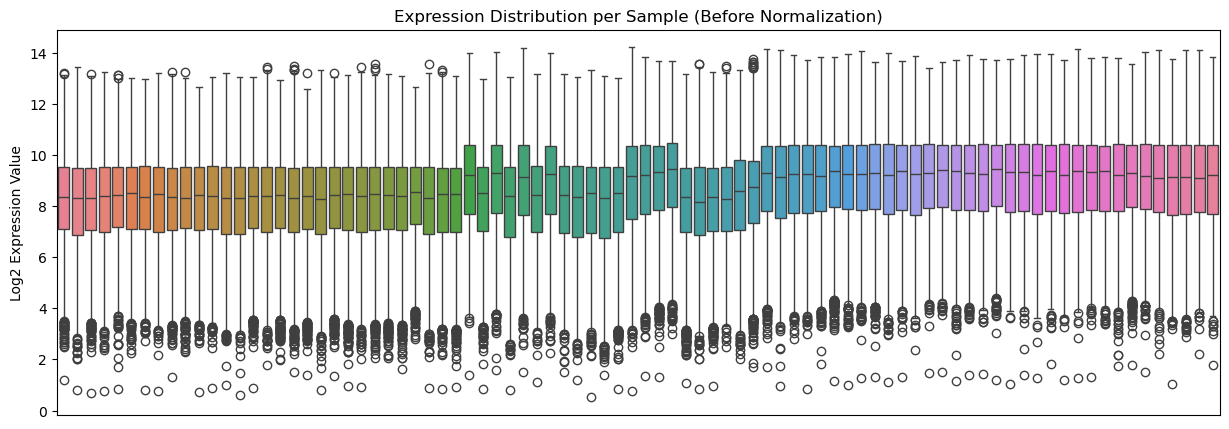

In [9]:
#visualing without normalisation
plt.figure(figsize=(15,5))
sns.boxplot(data=np.log2(expr + 1))
plt.title("Expression Distribution per Sample (Before Normalization)")
plt.xticks([], [])  # hide x-label clutter
plt.ylabel("Log2 Expression Value")
plt.show()


In [10]:
#normalization
from sklearn.preprocessing import StandardScaler

# Log2 transform
expr_log = np.log2(expr + 1)

# Scaling (samples as rows → transpose, scale, transpose back)
scaler = StandardScaler()
expr_scaled = pd.DataFrame(
    scaler.fit_transform(expr_log.T).T,
    index=expr_log.index,
    columns=expr_log.columns
)

expr_scaled.head()


,GSM398074,GSM398075,GSM398076,GSM398077,GSM398078,GSM398079,GSM398080,GSM398081,GSM398082,GSM398083,...,GSM398150,GSM398151,GSM398152,GSM398153,GSM398154,GSM398155,GSM398156,GSM398157,GSM398158,GSM398159
ID_REF,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at,-0.528427,-1.718653,-1.196644,0.810417,0.264007,0.067563,0.184771,0.774520,-0.319336,-1.131092,...,1.693730,1.214379,1.110351,1.327226,0.078073,1.130069,0.341669,0.391574,0.959568,0.644829
AFFX-BioB-M_at,-0.887883,-0.970752,-0.993457,-0.718218,-0.186459,-0.657003,-0.194717,0.634615,-1.638625,-0.539043,...,0.980725,-0.089411,1.654051,0.577996,2.288801,2.010134,0.241015,0.408371,0.538555,0.337505
AFFX-BioB-3_at,-0.290730,-2.374089,0.350790,-0.113427,-0.521823,-0.128302,-1.349936,-0.331679,-0.690891,-1.889545,...,0.566302,1.608271,0.204861,1.237820,1.467360,1.137297,0.348536,0.486025,1.107552,-0.276926
AFFX-BioC-5_at,-0.468277,-1.935211,-1.167287,0.229667,0.529686,0.470444,-0.876228,-0.554487,-0.325875,0.749362,...,1.336154,1.348387,1.872324,1.922883,0.556072,-1.397572,-0.123131,-0.603125,-0.772852,0.772617
AFFX-BioC-3_at,1.362683,0.686554,1.483373,0.424497,-0.014585,0.194381,-0.557196,-0.390782,0.462852,1.794802,...,-0.144745,0.101849,0.610949,0.289181,-0.093802,0.210531,-0.705119,0.719149,-0.263545,-1.166311


In [11]:
#label verification
print(pheno["status"].value_counts())


status
Normal    43
Cancer    43
Name: count, dtype: int64


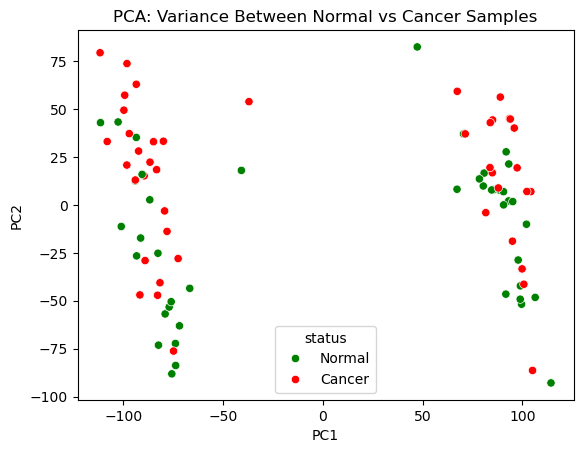

In [12]:
#PCA visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(expr_scaled.T)

pca_df = pd.DataFrame({
    "PC1": components[:,0],
    "PC2": components[:,1],
    "status": pheno["status"].values
})

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="status", palette=["green","red"])
plt.title("PCA: Variance Between Normal vs Cancer Samples")
plt.show()


In [13]:
#splitting data into groups
# Separate expression matrix into two groups based on phenotype labels
cancer_samples = pheno[pheno["status"] == "Cancer"].index
normal_samples = pheno[pheno["status"] == "Normal"].index

cancer = expr_scaled[cancer_samples]
normal = expr_scaled[normal_samples]

print("Cancer samples:", cancer.shape[1])
print("Normal samples:", normal.shape[1])


Cancer samples: 43
Normal samples: 43


In [14]:
#T-Test for every gene
from scipy.stats import ttest_ind

gene_stats = []

for gene in expr_scaled.index:
    # two-sample independent t-test
    t_stat, p_val = ttest_ind(cancer.loc[gene], normal.loc[gene])
    # compute log2 fold change (delta between group means)
    fold_change = (cancer.loc[gene].mean() - normal.loc[gene].mean())
    gene_stats.append([gene, p_val, fold_change])

stats_df = pd.DataFrame(gene_stats, columns=["gene", "p_value", "fold_change"])
stats_df.head()


,gene,p_value,fold_change
0,AFFX-BioB-5_at,0.882891,-0.032238
1,AFFX-BioB-M_at,0.938129,-0.016989
2,AFFX-BioB-3_at,0.202723,-0.277451
3,AFFX-BioC-5_at,0.359103,0.200214
4,AFFX-BioC-3_at,0.302842,-0.224797


In [15]:
#selecting significant genes
significant_genes = stats_df[stats_df["p_value"] < 0.05].sort_values("p_value")
print("Significant genes found:", significant_genes.shape[0])
significant_genes.head(10)


Significant genes found: 4823


,gene,p_value,fold_change
5544,205478_at,1.222092e-17,-1.527408
19043,219140_s_at,5.987370e-17,-1.506400
190,266_s_at,1.060824e-16,1.498572
22215,222317_at,2.725455e-16,-1.485336
1907,201839_s_at,5.462558e-16,1.475318
1718,201650_at,6.454732e-16,1.472879
10950,210964_s_at,1.308286e-15,-1.462403
20912,221009_s_at,1.680750e-15,-1.458629
19198,219295_s_at,3.965807e-15,-1.445451
5286,205220_at,5.860420e-15,-1.439328


In [16]:
#saving significant genes to csv
significant_genes.to_csv("significant_genes_GSE15852.csv", index=False)


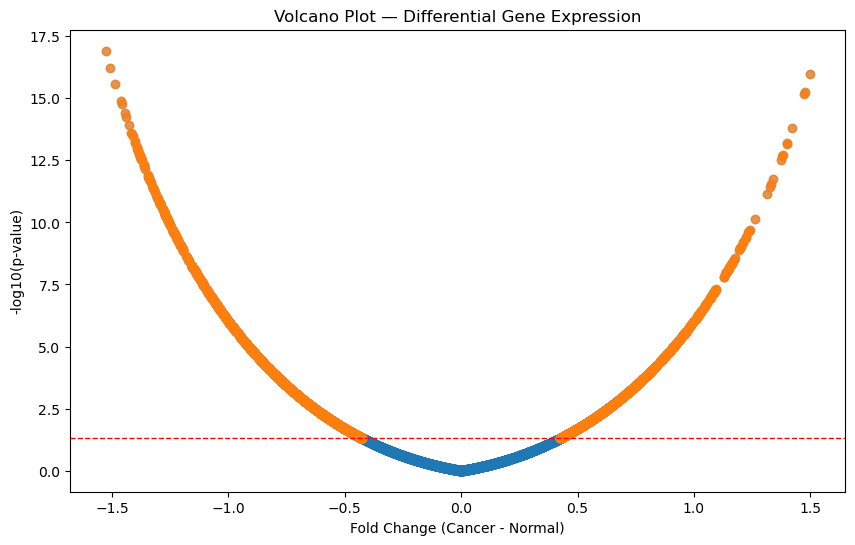

In [18]:
#Volcano plot
import matplotlib.pyplot as plt
import numpy as np

# For volcano plot: use -log10(p-value)
stats_df["neg_log10_p"] = -np.log10(stats_df["p_value"])

plt.figure(figsize=(10,6))
plt.scatter(stats_df["fold_change"], stats_df["neg_log10_p"], alpha=0.4)

# Highlight significant genes
sig = stats_df[stats_df["p_value"] < 0.05]
plt.scatter(sig["fold_change"], sig["neg_log10_p"], alpha=0.7)

plt.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1)
plt.title("Volcano Plot — Differential Gene Expression")
plt.xlabel("Fold Change (Cancer - Normal)")
plt.ylabel("-log10(p-value)")
plt.show()

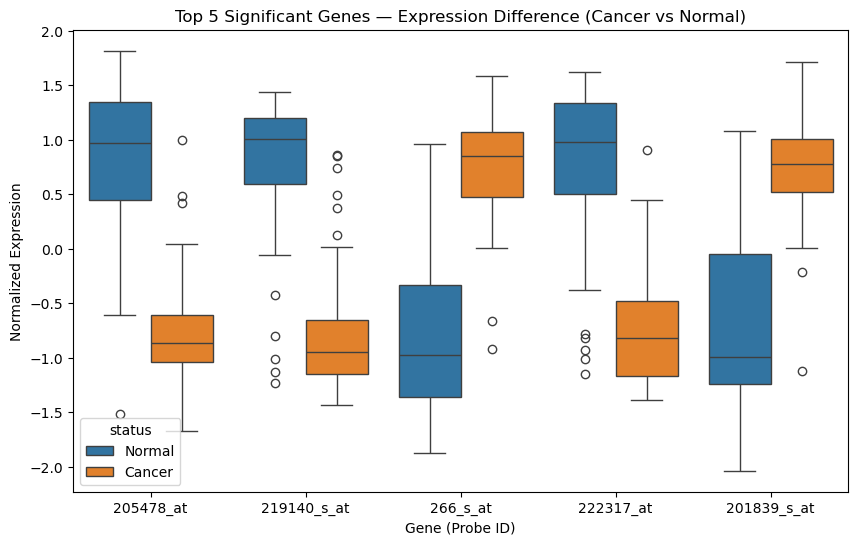

In [19]:
#Boxplots for Top 5 Most Significant Genes
import seaborn as sns
import pandas as pd

# Select top 5 most statistically significant genes
top5 = significant_genes.head(5)["gene"].tolist()

# Prepare melted dataframe for seaborn
plot_df = expr_scaled.loc[top5].T
plot_df["status"] = pheno["status"]

melted = plot_df.reset_index().melt(id_vars=["index","status"], 
                                    var_name="gene", value_name="expression")

plt.figure(figsize=(10,6))
sns.boxplot(data=melted, x="gene", y="expression", hue="status")
plt.title("Top 5 Significant Genes — Expression Difference (Cancer vs Normal)")
plt.xlabel("Gene (Probe ID)")
plt.ylabel("Normalized Expression")
plt.show()


In [20]:
#Convert Probe IDs to Gene Names
# Map probe IDs to gene symbols (GEOparse contains annotation tables)
annot = gse.gpls[list(gse.gpls.keys())[0]].table  # first platform (Affymetrix)

annot = annot[["ID", "Gene Symbol"]].rename(columns={"ID": "gene", "Gene Symbol": "symbol"})
stats_annotated = stats_df.merge(annot, on="gene", how="left")

# Replace NaN symbols with "Unknown"
stats_annotated["symbol"] = stats_annotated["symbol"].fillna("Unknown")

# Show the top annotated genes
stats_annotated.sort_values("p_value").head(10)


,gene,p_value,fold_change,neg_log10_p,symbol
5544,205478_at,1.222092e-17,-1.527408,16.912896,PPP1R1A
19043,219140_s_at,5.987370e-17,-1.506400,16.222764,RBP4
190,266_s_at,1.060824e-16,1.498572,15.974357,CD24
22215,222317_at,2.725455e-16,-1.485336,15.564561,PDE3B
1907,201839_s_at,5.462558e-16,1.475318,15.262604,EPCAM
1718,201650_at,6.454732e-16,1.472879,15.190122,KRT19
10950,210964_s_at,1.308286e-15,-1.462403,14.883297,GYG2
20912,221009_s_at,1.680750e-15,-1.458629,14.774497,ANGPTL4
19198,219295_s_at,3.965807e-15,-1.445451,14.401668,PCOLCE2
5286,205220_at,5.860420e-15,-1.439328,14.232071,HCAR3


In [33]:
#FDR (Benjamini–Hochberg) p-value correction
from statsmodels.stats.multitest import multipletests

# Add FDR corrected p-values
reject, p_adj, _, _ = multipletests(stats_df["p_value"], method="fdr_bh")

stats_df["p_adj"] = p_adj   # <-- This column must exist before collapsing
stats_df["significant"] = reject

stats_df.head()


,gene,p_value,log2FC,p_adj,significant
0,AFFX-BioB-5_at,0.882898,-0.032452,0.950279,False
1,AFFX-BioB-M_at,0.938133,-0.007974,0.974292,False
2,AFFX-BioB-3_at,0.203123,-0.184546,0.479113,False
3,AFFX-BioC-5_at,0.359103,0.134628,0.631114,False
4,AFFX-BioC-3_at,0.302935,-0.112936,0.582777,False


In [34]:
# Merge probe to gene symbol from annotation table
stats_annot = stats_df.merge(annot, on="gene", how="left")
stats_annot.rename(columns={"Gene Symbol": "symbol"}, inplace=True)

# Collapse multiple probes per gene → keep lowest FDR p-value probe
collapsed = (
    stats_annot.dropna(subset=["symbol"])
               .sort_values(["symbol", "p_adj"], ascending=[True, True])
               .groupby("symbol", as_index=False)
               .first()
)

collapsed.head(10)


,symbol,gene,p_value,log2FC,p_adj,significant
0,A1CF,220951_s_at,4.991582e-03,-0.325507,0.058092,False
1,A2M,217757_at,3.592406e-03,-0.453038,0.047227,True
2,A4GALT,219488_at,7.465584e-01,-0.039392,0.885824,False
3,A4GNT,221131_at,1.087454e-07,-0.910722,0.000011,True
4,AAAS,218075_at,1.653569e-03,-0.493652,0.027319,True
5,AACS,218434_s_at,1.934920e-01,-0.245154,0.468040,False
6,AADAC,205969_at,2.761258e-05,-1.062905,0.001129,True
7,AAGAB,202852_s_at,1.002639e-01,0.296157,0.335060,False
8,AAK1,214956_at,2.026973e-01,0.245967,0.478718,False
9,AAMDC,221599_at,2.064098e-04,-0.836986,0.005844,True


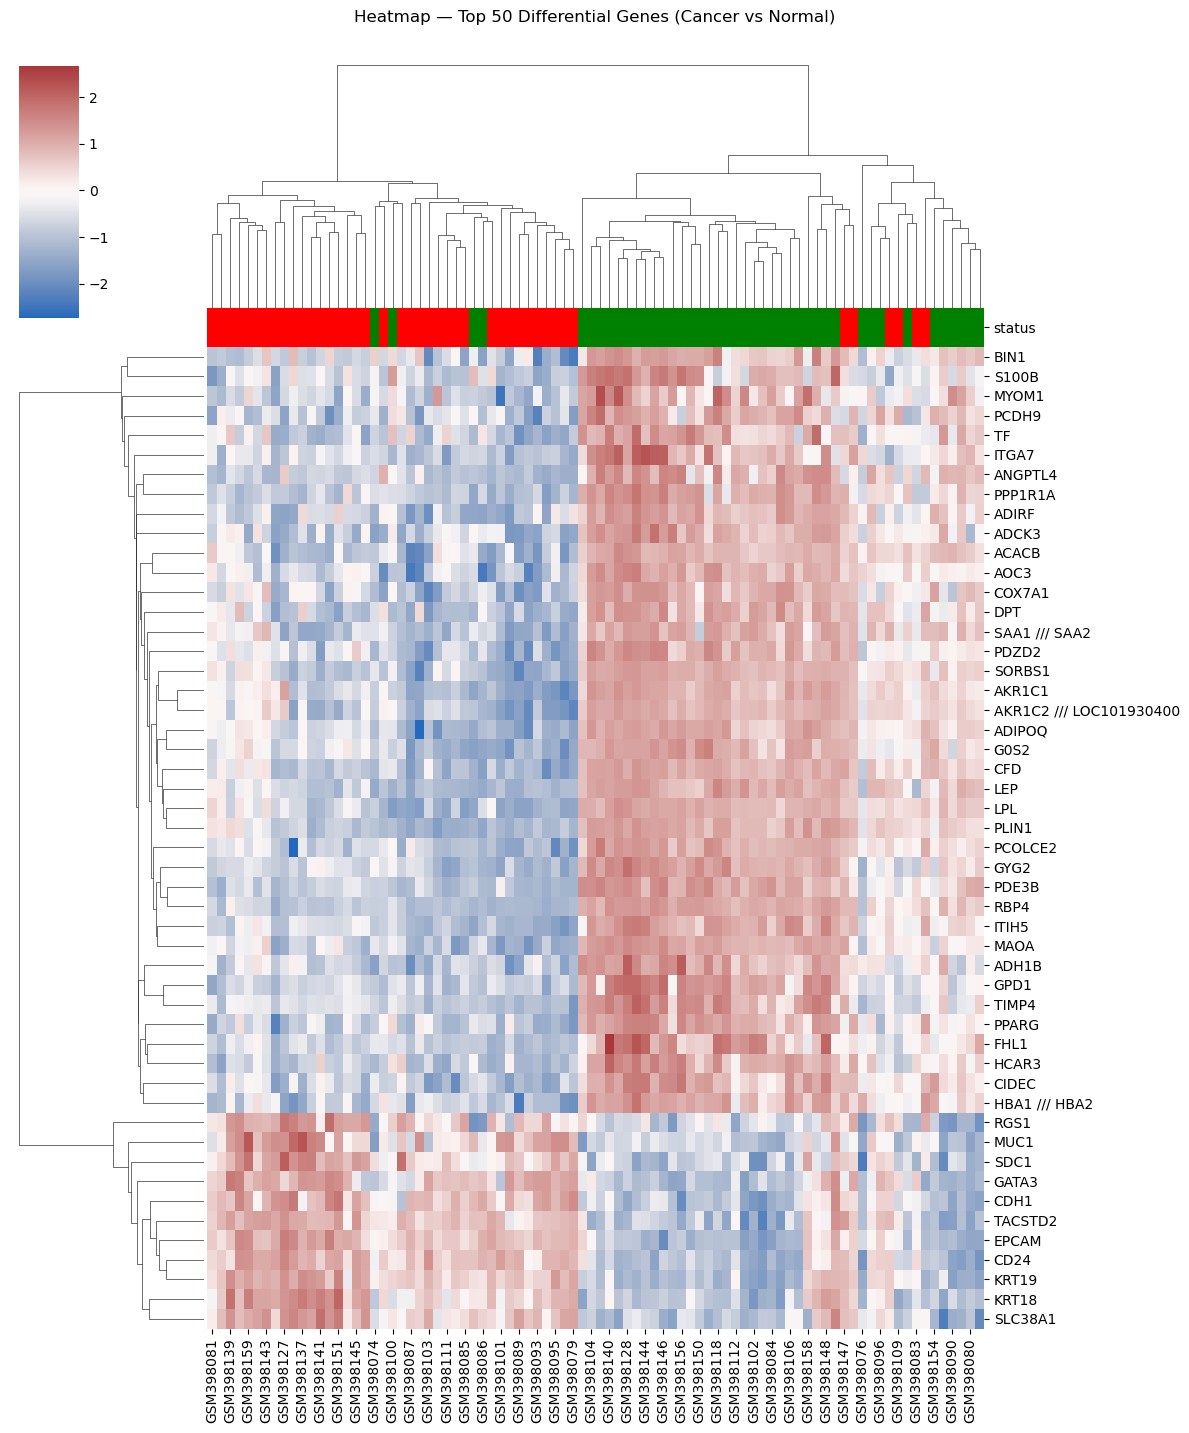

In [35]:
#Heatmap of Top Differential Genes (with clustering)

# Select top 50 genes after FDR correction
top_genes = collapsed.nsmallest(50, "p_adj")["symbol"].tolist()

# Map symbols back to probe IDs to extract expression values
# (collapsed already contains probe-level index)
probe_ids_for_top = collapsed[collapsed["symbol"].isin(top_genes)]["gene"].tolist()

# Extract expression log2 values (not scaled)
heatmap_matrix = expr_log.loc[probe_ids_for_top]

# Replace probe index with gene symbols
heatmap_matrix.index = collapsed.set_index("gene").loc[probe_ids_for_top]["symbol"].values

# Prepare column colors to indicate cancer vs normal samples
col_colors = pheno["status"].map({"Cancer": "red", "Normal": "green"})

sns.clustermap(
    heatmap_matrix,
    cmap="vlag",
    z_score=0,               # z-score rows (genes) for visible differences
    col_colors=col_colors,
    figsize=(12, 14)
)
plt.suptitle("Heatmap — Top 50 Differential Genes (Cancer vs Normal)", y=1.02)
plt.show()


In [36]:
collapsed.to_csv("GSE15852_final_significant_genes_with_symbols.csv", index=False)
